# Topic Modelling Neighborhood Overview: Verbs

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import glob as glob

In [7]:
def load_sample_data(country, city):
    directory = 'data/' + country + '/' + city + '/'
    csv_files = [file_name for file_name in glob.glob(directory + '*') if file_name[-4:] == '.csv']
    
    for file_loc in csv_files:
        file_name = file_loc.split('/')[3]
        
        if file_name == 'listings_sample.csv':
            #Read Listing Sample
            listing_sample = pd.read_csv(file_loc)
            
        elif file_name == 'reviews_sample.csv':
            #Read Review Sample
            reviews_sample = pd.read_csv(file_loc)
            
        elif file_name == 'neighbourhoods_sample.csv':
            #Read Neighborhoods
            neighbourhoods_sample = pd.read_csv(file_loc)
            
    return [listing_sample, reviews_sample, neighbourhoods_sample]


def load_full_data(country, city):
    directory = 'data/' + country + '/' + city + '/'
    csv_files = [file_name for file_name in glob.glob(directory + '*') if file_name[-4:] == '.csv']
    
    for file_loc in csv_files:
        file_name = file_loc.split('/')[3]
        
        if file_name == 'listings_full.csv':
            #Read Listings
            listings_full = pd.read_csv(file_loc).drop(columns=['Unnamed: 0'])
            
        elif file_name == 'reviews_full.csv':
            #Read Reviews
            reviews_full = pd.read_csv(file_loc).drop(columns=['Unnamed: 0'])
            
        elif file_name == 'calendar_full.csv':
            #Read Calendar
            calendar_full = pd.read_csv(file_loc).drop(columns=['Unnamed: 0'])
            
    return [listings_full, reviews_full, calendar_full]

In [9]:
listings_sf = pd.read_csv('../sf/listings_detailed.csv')

In [10]:
def clean_listing_full(listing_full_data):
    """Cleans listing_full.csv data"""
    # Input Data
    df = listing_full_data
    
    # String to Datetime
    df['last_scraped'] = pd.to_datetime(df['last_scraped'])
    df['host_since'] = pd.to_datetime(df['host_since'])
    df['calendar_last_scraped'] = pd.to_datetime(df['calendar_last_scraped'])
    df['first_review'] = pd.to_datetime(df['first_review'])
    df['last_review'] = pd.to_datetime(df['last_review'])
    
    # String to Numeric
    df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].str[:-1]) / 100
    df['price'] = pd.to_numeric(df['price'].str[1:].str.replace(',',''))
    df['weekly_price'] = pd.to_numeric(df['weekly_price'].str[1:].str.replace(',',''))
    df['monthly_price'] = pd.to_numeric(df['monthly_price'].str[1:].str.replace(',',''))
    df['security_deposit'] = pd.to_numeric(df['security_deposit'].str[1:].str.replace(',',''))
    df['cleaning_fee'] = pd.to_numeric(df['cleaning_fee'].str[1:].str.replace(',',''))
    df['extra_people'] = pd.to_numeric(df['extra_people'].str[1:].str.replace(',',''))

    # t/f to Numeric
    df['host_is_superhost'] = (df['host_is_superhost'] == "t").astype(int)
    df['host_has_profile_pic'] = (df['host_has_profile_pic'] == "t").astype(int)
    df['host_identity_verified'] = (df['host_identity_verified'] == "t").astype(int)
    df['is_location_exact'] = (df['is_location_exact'] == "t").astype(int)
    df['has_availability'] = (df['has_availability'] == "t").astype(int)
    df['requires_license'] = (df['requires_license'] == "t").astype(int)
    df['instant_bookable'] = (df['instant_bookable'] == "t").astype(int)
    df['is_business_travel_ready'] = (df['is_business_travel_ready'] == "t").astype(int)
    df['require_guest_profile_picture'] = (df['require_guest_profile_picture'] == "t").astype(int)
    df['require_guest_phone_verification'] = (df['require_guest_phone_verification'] == "t").astype(int)
    
    return df

In [11]:
clean_listings_sf = clean_listing_full(listings_sf)

In [12]:
listings_detailed = clean_listings_sf.copy()

ID = list(listings_detailed.iloc[:,:2].columns)

ABOUT_COLS = list(listings_detailed.iloc[:,3:15].columns)

PICS_COLS = list(listings_detailed.iloc[:,15:19].columns)

HOST_COLS = list(listings_detailed.columns[listings_detailed.columns.str.contains('host')])

NEIGHBORHOOD_COLS = list(listings_detailed.columns[listings_detailed.columns.str.contains('neighbourhood')])

LOCATION_COLS = list(listings_detailed.iloc[:,37:51].columns)

PROPERTY_COLS = list(listings_detailed.iloc[:,51:60].columns)

PRICE_COLS = list(listings_detailed.iloc[:,60:67].columns)

NIGHTS_COLS = list(listings_detailed.columns[listings_detailed.columns.str.contains('mum')])

AVAILABILITY_COLS = list(listings_detailed.columns[listings_detailed.columns.str.contains('availability')])

REVIEW_COLS = list(listings_detailed.columns[listings_detailed.columns.str.contains('review')])

SCRAPING_COLS = ['scrape_id','calendar_updated','calendar_last_scraped']

ELSE_COLS = ['requires_license', 'license', 'jurisdiction_names', 'instant_bookable',\
             'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture',\
             'require_guest_phone_verification']

## Neighborhood Info

In [13]:
neighborhood_info = clean_listings_sf[ID + NEIGHBORHOOD_COLS + ABOUT_COLS]

In [14]:
neighborhood_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7198 entries, 0 to 7197
Data columns (total 18 columns):
id                              7198 non-null int64
listing_url                     7198 non-null object
host_neighbourhood              6559 non-null object
neighbourhood                   6660 non-null object
neighbourhood_cleansed          7198 non-null object
neighbourhood_group_cleansed    0 non-null float64
last_scraped                    7198 non-null datetime64[ns]
name                            7198 non-null object
summary                         7000 non-null object
space                           6109 non-null object
description                     7183 non-null object
experiences_offered             7198 non-null object
neighborhood_overview           5310 non-null object
notes                           4486 non-null object
transit                         5238 non-null object
access                          4794 non-null object
interaction                     4931 non

In [15]:
neighborhood_overviews = neighborhood_info[['id','neighbourhood_cleansed','neighborhood_overview']].dropna()

## Clean & Tokenize Overview Text

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Get Stopwords
stop_words = set(stopwords.words('english'))

# Get Puncuations
punctuations = set(string.punctuation)

def clean_text(doc):
    
    # remove all ascii
    doc = re.sub(r'[^\x00-\x7F]+',' ', doc)

    # Tokenize, Lemmatize, and Remove Stopwords
    tokens = [lemmatizer.lemmatize(word).lower() for word in nltk.word_tokenize(doc) if word.lower() not in set(stop_words | punctuations)]
    
    return tokens

In [17]:
# Clean & Tokenize Overviews
neighborhood_overviews['tokens'] = neighborhood_overviews['neighborhood_overview'].apply(clean_text)

In [18]:
neighborhood_overviews['clean_overviews'] = neighborhood_overviews['tokens'].map(lambda x: ' '.join(x))

## Get POS

In [19]:
def get_pos_sentences(data):
    # Tokenize each sentence into words: token_sentences
    token_sentences = [nltk.word_tokenize(re.sub(r'[^\x00-\x7F]+',' ', sent)) for sent in data]

    # Tag each tokenized sentence into parts of speech: pos_sentences
    pos_sentences = [nltk.pos_tag(sent) for sent in token_sentences]
    return pos_sentences

In [22]:
# Initialize TextExtraction with DS Skills Listing
pos_overviews_neighborhood = get_pos_sentences(neighborhood_overviews['neighborhood_overview'])

## Verbs

In [23]:
def get_verbs(pos_sentences):
    """Return Verbs"""
    # Codes
    verb_code = ['VBG','VB','VBD','VBN','VBZ']

    # Get List of Adjectives
    verb_list = [[word[0].lower() for word in sent if word[1] in verb_code] for sent in pos_sentences]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    verb_lem_list = [[lemmatizer.lemmatize(verb, 'v') for verb in verb_sent] for verb_sent in verb_list]
        
    return verb_lem_list

In [24]:
verbs_overviews_neighborhood = get_verbs(pos_overviews_neighborhood)

In [26]:
neighborhood_overviews = neighborhood_overviews.reset_index(drop=True)

In [27]:
neighborhood_overviews['verbs'] = pd.Series(verbs_overviews_neighborhood)

In [57]:
neighborhood_overviews['verb_count'] = neighborhood_overviews['verbs'].map(lambda x : len(x))

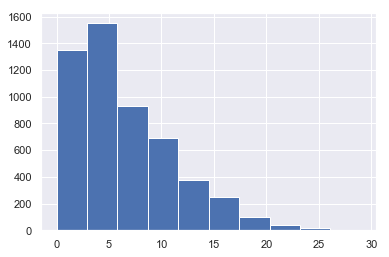

In [59]:
neighborhood_overviews['verb_count'].hist()

# Topic Modeling

In [37]:
token_texts = list(neighborhood_overviews['verbs'].values)

In [38]:
from gensim.corpora.dictionary import Dictionary

# Create a corpus from a list of texts
common_dictionary = Dictionary(token_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in token_texts]

In [60]:
from gensim.models.ldamulticore import LdaMulticore
import time
ldam = LdaMulticore

num_topics = 50
num_words = 5
passes = 50

# Get Start Time
start_time = time.time()

# LDA Model
ldam_model = ldam(common_corpus, num_topics=num_topics, id2word=common_dictionary, passes=passes)
model_end_time = time.time() # Model End Time

# LDA Results
results = ldam_model.print_topics(num_topics=num_topics, num_words=num_words)
result_time = time.time() # Results Time

In [61]:
ldam_model.save('../models/ldam_neighborhood_overviews_50topics_5words_50passes_verbs.model')

In [62]:
def display_results(results):
    for index, results in results:
        print(str(index) + ': ' + str(', '.join(results.split('"')[1::2])))

In [63]:
display_results(results)

0: be, situate, walk, use, know
1: be, shop, walk, try, explore
2: 's, be, have, know, compare
3: s, be, stay, stun, describe
4: be, feel, home, travel, range
5: do, have, be, see, neighborhood
6: find, be, step, walk, serve
7: check, take, be, allow, walk
8: be, eat, grab, drink, face
9: take, be, orient, drive, open
10: give, hear, walk, make, 's
11: be, have, live, rat, know
12: feature, be, nestle, represent, crowd
13: be, bustle, din, locate, rent
14: explore, be, offer, walk, catch
15: be, include, head, meet, host
16: walk, be, locate, rid, highway
17: offer, have, be, boast, inspire
18: be, explore, ride, put, spend
19: be, have, bring, recommend, do
20: be, excite, access, trail, boast
21: be, choose, walk, raise, invite
22: be, connect, have, anywhere, lay
23: go, be, make, have, visit
24: run, hike, be, walk, list
25: be, walk, have, lie, make
26: come, need, be, close, walk
27: create, seek, satisfy, lose, be
28: get, be, have, take, locate
29: work, be, tour, hang, ask
30:

In [64]:
def display_results_no_duplicates(results):
    all_lists = []
    for index, result in results:
        all_lists = all_lists + result.split('"')[1::2]
    
    # Get Counts of each word
    counts = pd.Series(all_lists).value_counts()
    no_duplicates = counts[counts == 1].index
    
    for index, result in results:
        print(str(index) + ': ' + str(', '.join([word for word in result.split('"')[1::2] if word in no_duplicates])))

In [65]:
display_results_no_duplicates(results)

0: situate, use
1: shop, try
2: compare
3: s, stun, describe
4: feel, home, travel, range
5: neighborhood
6: find, step, serve
7: check, allow
8: eat, grab, drink, face
9: orient, drive, open
10: hear
11: live, rat
12: feature, nestle, represent, crowd
13: bustle, din, rent
14: catch
15: head, meet, host
16: rid, highway
17: inspire
18: ride, put, spend
19: recommend
20: excite, access, trail
21: choose, raise, invite
22: connect, anywhere, lay
23: go
24: run, hike, list
25: lie
26: need, close
27: create, seek, satisfy, lose
28: get
29: work, tour, hang, ask
30: fill, grow
31: call, consider
32: sit, relax, *
33: charm, love, start
34: breathtaking, overlook
35: help, believe, appear
36: look, change, like, attract
37: park, dolores, leave
38: 
39: watch, play, swim
40: enjoy, hide
41: name, line, just, evolve
42: become, remain
43: block, bike, renowned
44: surround, border, keep, appreciate
45: refer, build, contain
46: amaze, bus
47: downtown
48: multiple, throw
49: want, mean, tuc

# By Neighborhood

In [43]:
tokens_by_neighborhood = neighborhood_overviews.groupby('neighbourhood_cleansed')[['verbs']].apply(sum)

# Topic Modeling

In [44]:
token_texts_by_neighborhood = list(neighborhood_overviews['verbs'].values)

In [45]:
from gensim.corpora.dictionary import Dictionary

# Create a corpus from a list of texts
common_dictionary_by_neighborhood = Dictionary(token_texts_by_neighborhood)
common_corpus_by_neighborhood = [common_dictionary_by_neighborhood.doc2bow(text) for text in token_texts_by_neighborhood]

In [46]:
from gensim.models.ldamulticore import LdaMulticore
import time
ldam = LdaMulticore

num_topics = 50
num_words = 10
passes = 50

# Get Start Time
start_time = time.time()

# LDA Model
ldam_model_by_neighborhood = ldam(common_corpus_by_neighborhood, num_topics=num_topics, id2word=common_dictionary_by_neighborhood, passes=passes)
model_end_time = time.time() # Model End Time

# LDA Results
results_by_neighborhood = ldam_model_by_neighborhood.print_topics(num_topics=num_topics, num_words=num_words)
result_time = time.time() # Results Time

In [47]:
ldam_model_by_neighborhood.save('../models/ldam_overview_by_neighborhood_50topics_10words_50passes_verbs.model')

In [49]:
display_results(results_by_neighborhood)

0: be, offer, explore, try, walk, thrive, appeal, mix, allow, stop
1: be, climb, take, locate, walk, show, commute, occupy, shuttle, 's
2: be, serve, live, find, travel, stock, discover, own, come, give
3: be, visit, get, tuck, host, offer, maintain, own, sip, locate
4: be, shop, locate, sit, walk, drive, anywhere, lie, freeway, teem
5: see, be, watch, neighborhood, walk, do, have, take, surf, lay
6: stay, bike, beautiful, support, carry, happen, imagine, frame, bart, o
7: be, border, have, say, locate, make, populate, ask, walk, famed
8: open, reach, rent, own, be, invite, beloved, laugh, designate, bike
9: run, charm, be, have, create, roll, walk, encompass, locate, stop
10: be, situate, walk, stun, feel, know, explore, get, happen, live
11: be, din, start, grab, locate, walk, remodel, have, love, jump
12: be, feature, name, build, just, evolve, range, have, detach, wind
13: enjoy, park, be, walk, have, list, dolores, head, leave, jog
14: be, have, take, locate, 's, see, paint, know,

In [54]:
display_results_no_duplicates(results_by_neighborhood)

0: thrive, appeal, mix
1: climb, show, commute, shuttle
2: serve, travel, stock, discover
3: tuck, maintain, sip
4: shop, sit, anywhere, lie, freeway, teem
5: neighborhood, surf, lay
6: stay, beautiful, support, carry, frame, bart, o
7: border, populate, ask, famed
8: open, reach, rent, invite, beloved, laugh, designate
9: run, create, roll, encompass
10: stun
11: din, start, remodel, jump
12: name, build, just, evolve, range, detach, wind
13: park, list, dolores, jog
14: paint, cost
15: overlook, connect, breathtaking, melt, remove
16: downtown, need, relax, depend
17: hide, turn, cook, dance, whisk
18: surround, line
19: hike, require, pack, mention, set
20: put, wander, learn
21: eat, drink, lose
22: rat
23: accord, picnic, buy
24: crowd, transform, contain, face
25: renovate, hold, develop, dominate
26: navigate, |, withing, source, historic, muni, kid
27: fill, grow, *, tour
28: 
29: step, home, orient, help, welcome
30: note, dine, beat
31: s, draw, restaurants
32: stroll, cover,